# GPU Accellerated Data Analytics & Machine Learning - Tutorial

## Installing Dependencies

In [1]:
!nvidia-smi

Sat Jul 20 09:41:54 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    18W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)

# In case you don't have the right instance, go to the Runtime option on Google
# Colab then select change runtime type and make sure GPU is selcted. 
# If you get assigned a GPU which is not the Tesla T4, then go to runtime
# select Reset all runtimes and try to run again the first two cells of this 
# notebook
if device_name != b'Tesla T4':
  raise Exception("Unfortunately this instance does not have a T4 GPU.")
else:
  print('Woo! You got the right kind of GPU!')

Woo! You got the right kind of GPU!


In [6]:
# intall miniconda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# install RAPIDS packages
!conda install -q -y --prefix /usr/local -c conda-forge \
  -c rapidsai-nightly/label/cuda10.0 -c nvidia/label/cuda10.0 \
  cudf cuml

# set environment vars
import sys, os, shutil
sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

# copy .so files to current working dir
for fn in ['libcudf.so', 'librmm.so']:
  shutil.copy('/usr/local/lib/'+fn, os.getcwd())

--2019-07-20 09:47:23--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 

## Example 1

In this example I will walk you though how to use RAPIDS libraries cudf and xgboost to preprocess a dataset and then use XGBoost (optimized distributed gradient boosting) to train, make predictions and finally evaluate the model accuracy. Successively I will perform the same tasks using Pandas and Sklearn. For this demonstration I will make use of the Pima Indians Diabetes Dataset: https://www.kaggle.com/uciml/pima-indians-diabetes-database

### RAPIDS

In [0]:
# In case you get an import error, run again notebook cell number 3, 
# to install again miniconda and RAPIDS dependencies. If the problem persists,
# Go to Runtime -> Reset all runtimes and then run again the noebook cells (two 
# times the one for installing miniconda and RAPIDS dependencies)
import cudf
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [0]:
df_cudf = cudf.read_csv('/content/pima_indian_data.csv') 
df_cudf.head().to_pandas()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [0]:
# Encoding labels
uniques = {}
uniques['Outcome'] = df_cudf['Outcome'].unique_k(k=1000)
cats = uniques['Outcome'][1:]  # drop first
df_cudf = df_cudf.one_hot_encoding('Outcome', prefix='Outcome', cats=cats)

# making sure that all the columns used for classification are of float type
for k in df_cudf.columns:
    df_cudf[k] = df_cudf[k].astype(float)
    
# Dividing the dataset in features and labels
X = df_cudf.drop(['Outcome', 'Outcome_1'], axis = 1).to_pandas().values

y = df_cudf['Outcome_1'].to_pandas().values

# df_cudf.head().to_pandas()

# Alternatively:
# num_rows, num_columns = df_cudf.shape
# X = df_cudf.drop(['Outcome', 'Outcome_1'], axis = 1)
# X = X.as_gpu_matrix(columns=df_cudf.iloc[:,0:num_columns-2])

# y = cudf.DataFrame({'Outcome_1' : df_cudf['Outcome_1']})
# y = y.as_gpu_matrix(columns=y.columns)

In [0]:
train_size = 0.80

# identify shape and indices
num_rows, num_columns = df_cudf.shape
delim_index = int(num_rows * train_size)

# Splitting the dataset in training and test sets
X_train, y_train = X[:delim_index, :], y[:delim_index]
X_test, y_test = X[delim_index:, :], y[delim_index:]

# Checking sets dimensions
print('X_train dimensions: ', X_train.shape, 'y_train: ', y_train.shape)
print('X_test dimensions:', X_test.shape, 'y_validation: ', y_test.shape)

# Checking dimensions in percentages
total = X_train.shape[0] + X_test.shape[0]
print('X_train Percentage:', (X_train.shape[0]/total)*100, '%')
print('X_test Percentage:', (X_test.shape[0]/total)*100, '%')

#X_train.as_gpu_matrix(columns=X.columns)

X_train dimensions:  (614, 8) y_train:  (614,)
X_test dimensions: (154, 8) y_validation:  (154,)
X_train Percentage: 79.94791666666666 %
X_test Percentage: 20.052083333333336 %


In [0]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [0]:
%%time

# Initial xgb parameters
params = {}

clf = xgb.train(params, dtrain)

CPU times: user 28.6 ms, sys: 1.83 ms, total: 30.4 ms
Wall time: 27.6 ms


In [0]:
%%time

rapids_pred = clf.predict(dtest)
rapids_pred

CPU times: user 5.69 ms, sys: 1.37 ms, total: 7.07 ms
Wall time: 7.69 ms


In [0]:
rapids_pred = np.round(rapids_pred)
rapids_acc = accuracy_score(y_test, rapids_pred)
print("XGB accuracy using RAPIDS:", rapids_acc*100, '%')

XGB accuracy using RAPIDS: 75.97402597402598 %


### Sklearn

In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from xgboost import XGBClassifier

In [0]:
df = pd.read_csv("/content/pima_indian_data.csv")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [0]:
X = df.drop(['Outcome'], axis = 1).values
y = df['Outcome']

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Checking sets dimensions
print('X_train dimensions: ', X_train.shape, 'y_train: ', y_train.shape)
print('X_test dimensions:', X_test.shape, 'y_validation: ', y_test.shape)

# Checking dimensions in percentages
total = X_train.shape[0] + X_test.shape[0]
print('X_train Percentage:', (X_train.shape[0]/total)*100, '%')
print('X_test Percentage:', (X_test.shape[0]/total)*100, '%')

X_train dimensions:  (614, 8) y_train:  (614,)
X_test dimensions: (154, 8) y_validation:  (154,)
X_train Percentage: 79.94791666666666 %
X_test Percentage: 20.052083333333336 %


In [0]:
%%time

model = XGBClassifier()
model.fit(X_train, y_train)

CPU times: user 41.6 ms, sys: 2.01 ms, total: 43.6 ms
Wall time: 44.6 ms


In [0]:
%%time

sk_pred = model.predict(X_test)
sk_pred

CPU times: user 2.42 ms, sys: 2 µs, total: 2.42 ms
Wall time: 2.44 ms


In [0]:
sk_pred = np.round(sk_pred)
sk_acc = accuracy_score(y_test, sk_pred)
print("XGB accuracy using Sklearn:", sk_acc*100, '%')

XGB accuracy using Sklearn: 75.32467532467533 %


As result of this analysis, using RAPIDS libraries lead to a faster exacution (eg. 713 µs for training vs 44.6 ms) and sligthly better accuracy. 

## Example 2

In this example I will insted use Pandas for the preprocessing of both the RAPIDS and Sklearn classifiers and I will also fabricate a dataset of bigger dimensions compared to the Pima Diabetes Indian Dataset. In this way it will become more evident how RAPIDS can axcellerate data analysis execution.

### Preprocessing

In [0]:
# Creating a linearly separable dataset using Gaussian Distributions.
# The first half of the number in Y is 0 and the other half 1.
# Therefore I made the first half of the two features quite different from
# the second half of the features (setting the value of the means quite 
# similar) so that make quite simple the classification between the 
# classes (the data is linearly separable).
dataset_len = 8000000
dlen = int(dataset_len/2)
X_11 = pd.Series(np.random.normal(2,2,dlen))
X_12 = pd.Series(np.random.normal(9,2,dlen))
X_1 = pd.concat([X_11, X_12]).reset_index(drop=True)
X_21 = pd.Series(np.random.normal(1,3,dlen))
X_22 = pd.Series(np.random.normal(7,3,dlen))
X_2 = pd.concat([X_21, X_22]).reset_index(drop=True)
X_31 = pd.Series(np.random.normal(3,1,dlen))
X_32 = pd.Series(np.random.normal(3,4,dlen))
X_3 = pd.concat([X_31, X_32]).reset_index(drop=True)
Y = pd.Series(np.repeat([0,1],dlen))
df = pd.concat([X_1, X_2, X_3, Y], axis=1)
df.columns = ['X1', 'X2', 'X3', 'Y']
df.head()

,X1,X2,X3,Y
0,0.879987,3.121732,4.077546,0
1,1.492813,0.985051,2.971663,0
2,1.490237,0.875160,2.073321,0
3,3.747358,5.388664,4.040363,0
4,2.343462,1.030326,2.791691,0


In [0]:
X = df.drop(['Y'], axis = 1).values
y = df['Y']

In [0]:
def preproces(df, X, y, train_size = 0.80):
  # label_encoder object knows how to understand word labels. 
  label_encoder = preprocessing.LabelEncoder() 

  # Encode labels
  y = label_encoder.fit_transform(y) 

  # identify shape and indices
  num_rows, num_columns = df.shape
  delim_index = int(num_rows * train_size)

  # Splitting the dataset in training and test sets
  X_train, y_train = X[:delim_index, :], y[:delim_index]
  X_test, y_test = X[delim_index:, :], y[delim_index:]

  # Checking sets dimensions
  print('X_train dimensions: ', X_train.shape, 'y_train: ', y_train.shape)
  print('X_test dimensions:', X_test.shape, 'y_validation: ', y_test.shape)

  # Checking dimensions in percentages
  total = X_train.shape[0] + X_test.shape[0]
  print('X_train Percentage:', (X_train.shape[0]/total)*100, '%')
  print('X_test Percentage:', (X_test.shape[0]/total)*100, '%')
  
  return X_train, y_train, X_test, y_test

In [0]:
X_train, y_train, X_test, y_test = preproces(df, X, y)

X_train dimensions:  (6400000, 3) y_train:  (6400000,)
X_test dimensions: (1600000, 3) y_validation:  (1600000,)
X_train Percentage: 80.0 %
X_test Percentage: 20.0 %


### RAPIDS

In [0]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [0]:
%%time

# Initial xgb parameters
params = {}

clf = xgb.train(params, dtrain)

[18:59:06] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
CPU times: user 1min 59s, sys: 197 ms, total: 2min
Wall time: 2min


In [0]:
%%time

rapids_pred = clf.predict(dtest)
rapids_pred

CPU times: user 624 ms, sys: 3.01 ms, total: 627 ms
Wall time: 633 ms


In [0]:
rapids_pred = np.round(rapids_pred)
rapids_acc = round(accuracy_score(y_test, rapids_pred), 2)
print("XGB accuracy using RAPIDS:", rapids_acc*100, '%')

XGB accuracy using RAPIDS: 98.0 %


### Sklearn

In [0]:
%%time

model = XGBClassifier()
model.fit(X_train, y_train)

[19:01:59] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
CPU times: user 11min 44s, sys: 670 ms, total: 11min 44s
Wall time: 11min 44s


In [0]:
%%time

sk_pred = model.predict(X_test)
sk_pred

CPU times: user 3.64 s, sys: 4 ms, total: 3.65 s
Wall time: 3.65 s


In [0]:
sk_pred = np.round(sk_pred)
sk_acc = round(accuracy_score(y_test, sk_pred), 2)
print("XGB accuracy using Sklearn:", sk_acc*100, '%')

XGB accuracy using Sklearn: 98.0 %


As can be seen in this demonstration, using RAPIDS axcellerated training times by about 5.5x (2 minutes vs 11 minutes)

## Example 3

In this exaple I will walk you through how to use Linear Regression using the CUML RAPIDS library and then compare the results with the same anaylis using Sklearn. Also for this example I fabricated a dataset, this time suitable for a regression analysis. The CUML library provides many other algorithms such as Random Forest, K-Nearest-Neighbour (KNN) and Stochastic Gradient Descent. If you want to find out more, you can refer here to the official documentation: https://github.com/rapidsai/cuml

### Preprocessing

In [0]:
from math import exp
import cuml
from cuml import LinearRegression as cuLinearRegression
from sklearn.linear_model import LinearRegression as skLinearRegression
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

In [0]:
N = 10000

house_price = [0.27*exp(-0.27*_) for _ in range(0,N)] 
house_price = np.array(house_price,dtype=np.float64)
# Normalize data to prevent inf loss
house_price = pd.Series(house_price/house_price.max(axis=0))

house_age = range(0, N) 
house_age = np.array(house_age,dtype=np.float64)
# Normalize data to prevent inf loss
house_age = pd.Series(house_age/house_age.max(axis=0))

X = pd.concat([house_price, house_age], axis=1)

houses_sold = [0.01*exp(0.015*_) for _ in range(0,N)]
houses_sold = np.array(houses_sold,dtype=np.float64)
# Normalize data to prevent inf loss
y = pd.Series(houses_sold/houses_sold.max(axis=0))

df = pd.concat([house_price, house_age, y], axis=1)
df.columns = ['house_price', 'house_age', 'houses_sold']
df.head()

,house_price,house_age,houses_sold
0,1.000000,0.0000,7.283534e-66
1,0.763379,0.0001,7.393610e-66
2,0.582748,0.0002,7.505350e-66
3,0.444858,0.0003,7.618779e-66
4,0.339596,0.0004,7.733922e-66


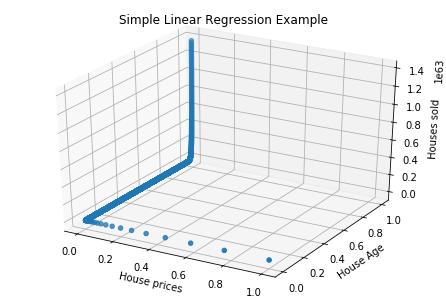

In [0]:
fig = pyplot.figure()
ax = Axes3D(fig)


ax.scatter(house_price, house_age, houses_sold)
ax.set_xlabel('House prices')
ax.set_ylabel('House Age')
ax.set_zlabel('Houses sold')
ax.set_title('Simple Linear Regression Example')

plt.show()

In [0]:
def regr_preproces(df, X, y, train_size = 0.80):

  # identify shape and indices
  num_rows, num_columns = df.shape
  delim_index = int(num_rows * train_size)

  # Splitting the dataset in training and test sets
  X_train, y_train = X[:delim_index, :], y[:delim_index]
  X_test, y_test = X[delim_index:, :], y[delim_index:]

  # Checking sets dimensions
  print('X_train dimensions: ', X_train.shape, 'y_train: ', y_train.shape)
  print('X_test dimensions:', X_test.shape, 'y_validation: ', y_test.shape)

  # Checking dimensions in percentages
  total = X_train.shape[0] + X_test.shape[0]
  print('X_train Percentage:', (X_train.shape[0]/total)*100, '%')
  print('X_test Percentage:', (X_test.shape[0]/total)*100, '%')
  
  return X_train, y_train, X_test, y_test

In [0]:
X_train, y_train, X_test, y_test = regr_preproces(df, X.values, y.values)

X_train dimensions:  (8000, 2) y_train:  (8000,)
X_test dimensions: (2000, 2) y_validation:  (2000,)
X_train Percentage: 80.0 %
X_test Percentage: 20.0 %


### RAPIDS

In [0]:
%%time
# run the cuml linear regression model to fit the training dataset 
rapids = cuLinearRegression(fit_intercept=True,
                  normalize=True,
                  algorithm='eig')
rapids.fit(X_train, y_train)

CPU times: user 112 ms, sys: 6.44 ms, total: 118 ms
Wall time: 119 ms


In [0]:
%%time
# calculate the mean squared error of the testing dataset using the cuml linear regression model
rapids_pred = rapids.predict(X_test).to_array()
rapids_loss = mean_squared_error(y_test, rapids_pred)
print("Linear Regression Mean Squared Error loss using RAPIDS:", rapids_loss)

CPU times: user 3.46 ms, sys: 538 µs, total: 4 ms
Wall time: 5.22 ms


### Sklearn

In [0]:
%%time
# use the sklearn linear regression model to fit the training dataset 
sk = skLinearRegression(fit_intercept=True,
                  normalize=True)
sk.fit(X_train, y_train)

CPU times: user 3.68 ms, sys: 183 µs, total: 3.86 ms
Wall time: 21.7 ms


In [0]:
%%time
# calculate the mean squared error of the sklearn linear regression model on the testing dataset
sk_pred = sk.predict(X_test)
sk_loss = mean_squared_error(y_test, sk_pred)
print("Linear Regression Mean Squared Error loss using Sklearn:", sk_loss)

CPU times: user 671 µs, sys: 199 µs, total: 870 µs
Wall time: 676 µs


## Example 5

Rapids has additionally also support of another library called CuGraph which is used to create Graph Neural Network (GNN). GNNs have applications in: social network, knowledge graph, recommender system, and even life science. GNNs are used to model dependencies between nodes in a graph. If you are interested in finding out more, please refere to the documentation: https://github.com/rapidsai/notebooks/tree/branch-0.9/cugraph or to my RAPIDS: CuGraph tutorial on GitHub.

## Example 6

Another library supported by RAPIDS is Dask. Dask is a library the allows for parallelized computing. Written in Python, it allows one to compose complex workflows using large data structures like those found in NumPy, Pandas, and cuDF. Dask operates by creating a cluster composed of a "client" and multiple "workers". The client is responsible for scheduling work; the workers are responsible for actually executing that work. If you are interested in finding out more, please refere to the documentation: https://github.com/rapidsai/notebooks-extended/tree/master/getting_started_notebooks/intro_tutorials or to my RAPIDS: Dask tutorial on GitHub.